## Map Shoreline

The following steps analyse the process used in CoastSnap to map the shoreline on the image.
The overall process is controlled from the function file CSPGmapShoreline.m.
Below are the main steps which are performed.

### 1. Get data from the plan image (georectified) and check if the shoreline has already been mapped.
### 2. Load transect data from the Shorelines file.
### 3. Call mapShorelineCCD.m to determine the shoreline location:

> #### 3.1 Extract pixel RGB (red, green, blue) values for points along each transect:

First load the file with the necessary variables for running the folling demonstrations:
<br>**Note:** you must alter the path in add path to match the location of 'MATLAB Notebooks' on your machine.

In [1]:
%alter the path in the add path function to match your own
addpath('/Users/nickheaney/Desktop/MATLAB Notebooks')
load('MapShoreline.mat');

***improfile*** identifies the rgb pixel intensities. The function inputs are:
- xgrid : x coordinate system (within image limits)
- ygrid : y coordinate system (within image limits)
- Iplan : (plan) input image
- transects.x : x-coordinates of the transect start and end points
- transects.y : y-coordinates of the transect start and end points

In [2]:
%plot native
P = improfile(xgrid,ygrid,Iplan,transects.x,transects.y);
improfile(xgrid,ygrid,Iplan,transects.x,transects.y)

In the above cell, move '%plot native' to below '%plot inline' this will plot the 3D graph in a separate window, allowing you do rotate it and get a better understanding of what it represents. For example, view the graph from above or perpendicular to a transect:
<table><tr><td><img src='improfileAbove.png'></td><td><img src='improfilePerp.png'></td></tr></table>

> #### 3.2 Create a probability density estimate for the range of red minus blue values of the pixels:

The RGB pixel intensity data are now represented by the variable **P**. **P** is an n $*$ 1 $*$ 3 array (where n is the number of pixels sampled along the transects in the previous step). The final dimension of the array is 3 because there are values corresponding to each of the 3 colours: red; green; and blue.

CoastSnap only uses the red and blue colour values. It subtracts the red intensity from the blue intensity (RmB). For the pixels in the variable P, their RmB values are represented by:

In [3]:
P(:,:,1)-P(:,:,3);

These RmB values are used as the input for the next function to be called, ***ksdensity***. This finction creates a probability density describing the likelyhood of each RmB value from in the pixels provided:

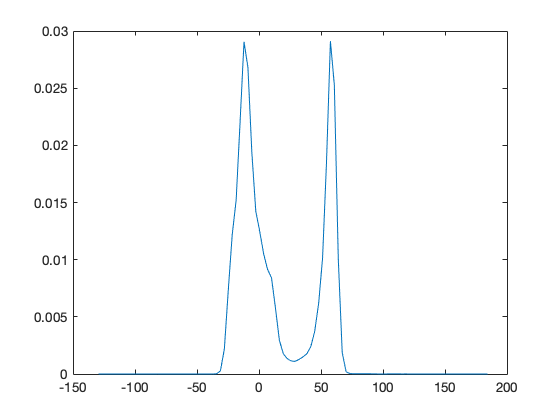

In [4]:
%plot inline
[pdf_values,pdf_locs] = ksdensity(P(:,:,1)-P(:,:,3));
ksdensity(P(:,:,1)-P(:,:,3))

> #### 3.3 Determine the threshold RmB value (the value for the pixels along the shoreline):

The RmB probability density is now used to determine the threshold value representing the shoreline.

First the threshold weightings (which can be adapted to the each individual beach) are defined. These weightings are used to determine the location of the optimum point (RmB value) between the two peaks of the probability density. When downloading CoastSnap the weightings are set at [ 1/3  2/3 ]. That is, the threshold, **RmB<sub>opt</sub> = 1/3 RmB<sub>wet</sub> + 2/3 RmB<sub>dry</sub>**. These are the default threshold weightings because they are the most suitable for South-East Australia. They can be altered regions where sand and ocean colours are different to those in Australia.

In [5]:
thresh_weightings = [1/3 2/3];

To perform the calculation, **RmB<sub>wet</sub>** and **RmB<sub>dry</sub>** must be identified. This requires the RmB values to be classified as wet or dry. This is done by the Otsu method, performed using the ***multithresh*** function.

In [6]:
thresh_otsu = multithresh(P(:,:,1)-P(:,:,3))


thresh_otsu =

   23.4235



The value representing **RmB<sub>wet</sub>** is the peak on the probability density plot corresponding to the lower RmB value (the left peak). This is due to the high blue intensity and low red intensity of these pixels. This peak value is now found:

In [7]:
I1 = find(pdf_locs<thresh_otsu);
[~,J1] = max(pdf_values(I1));

Conversely, the value representing **RmB<sub>dry</sub>** is the peak on the probability density plot corresponding to the higher RmB value (the left peak). Here there is a low blue intensity and a high red intensity of the pixels. This peak value is now found:

In [8]:
I2 = find(pdf_locs>thresh_otsu);
[~,J2] = max(pdf_values(I2));

Now the threshold value, **RmB<sub>opt</sub>** is found:

In [9]:
RmBwet = pdf_locs(I1(J1));
RmBdry = pdf_locs(I2(J2));
thresh_otsu;

thresh = thresh_weightings(1)*RmBwet + thresh_weightings(2)*RmBdry


thresh =

   34.3645



The above steps are represented in the plot generated by the code below which is carried out by the **if plotoption == 1** statement.

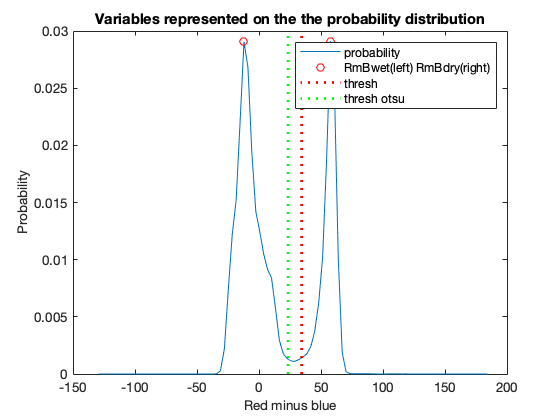

In [10]:
%plot_inline
plot(pdf_locs,pdf_values,'DisplayName','probability')
hold on
plot(pdf_locs([I1(J1) I2(J2)]),pdf_values([I1(J1) I2(J2)]),'ro','DisplayName','RmBwet(left) RmBdry(right)')
YL = ylim;
plot([thresh thresh], YL,'r:','linewidth',2,'DisplayName','thresh')
plot([thresh_otsu thresh_otsu], YL,'g:','linewidth',2,'DisplayName','thresh otsu')
xlabel(xlabel_type,'fontsize',10)
ylabel('Probability','fontsize',10)
title('Variables represented on the the probability distribution')

legend

> #### 3.4 Extract the contours at the threshold value (the same value as the shoreline):

Firstly the RmB values for all of the pixels within the image are found (in the previous steps only values along the tranects were taken). The two images below make what is happening clearer:

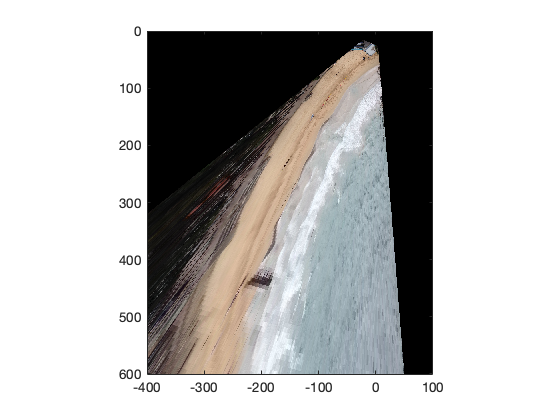

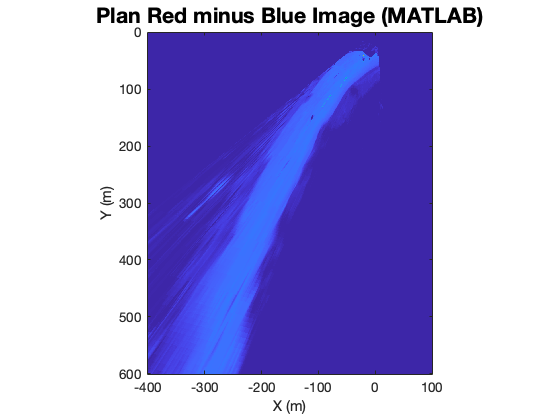

In [11]:
%plot inline
RminusBdouble = double(Iplan(:,:,1))- double(Iplan(:,:,3));
image(xgrid,ygrid,Iplan)
axis equal
axis tight
figure
image(xgrid,ygrid,RminusBdouble)
axis equal
axis tight
title('Plan Red minus Blue Image (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')

The region of interest is defined next by using the coordinates of the transect start and end points. The plot below illustrates the region being defined:

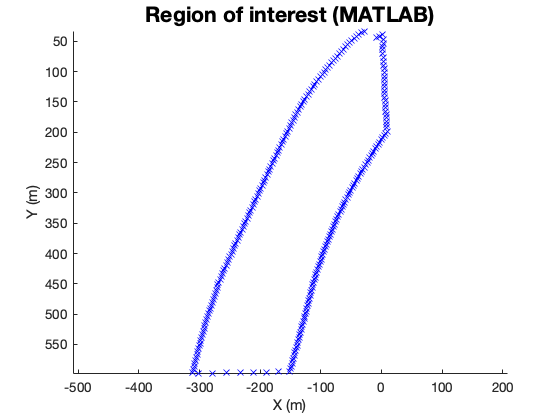

In [12]:
ROIx = [transects.x(1,:) fliplr(transects.x(2,:))];
ROIy = [transects.y(1,:) fliplr(transects.y(2,:))];
scatter(ROIx, ROIy, 'bx')
axis ij
title('Region of interest (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal

The function ***inpoly*** is used to fully define the polygon bounded by these points. The region outside of the region of interest is then masked. <br> **Note: *inpoly*** (funtion included in the CoastSnap package) is not the same as ***inpolygon*** (built in MATLAB function).

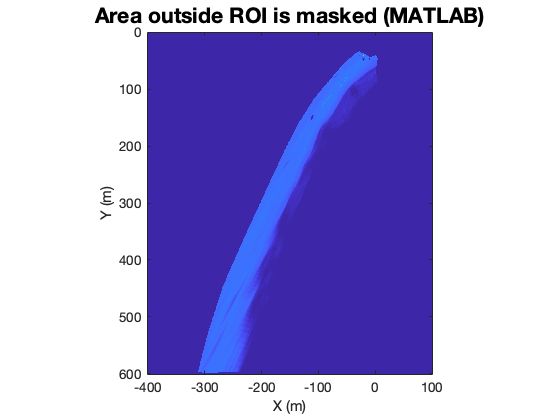

In [14]:
Imask = ~inpoly([X(:) Y(:)],[ROIx',ROIy']);
RminusBdouble(Imask) = NaN;
image(xgrid,ygrid,RminusBdouble)
title('Area outside ROI is masked (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

**Note**: if ***inpoly*** not working above, make sure that the correct path to the CoastSnap Code folder has been added to the MATLAB path.

The function ***contours*** is then called with the region of interest and the threshold as the inputs (X and Y and meshgrids defined by xgrid and ygrid at the top of mapShorelineCCD.m). This locates the shoreline. The images generated demontrate how this works. <br> **Note:** The images have been generated using ***contour*** not ***contours***. These seem to give the same output but they are not the same function.

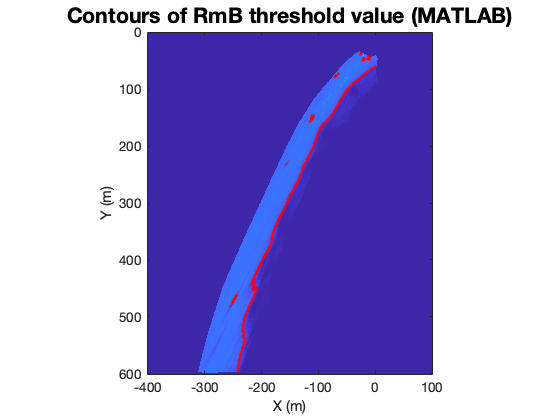

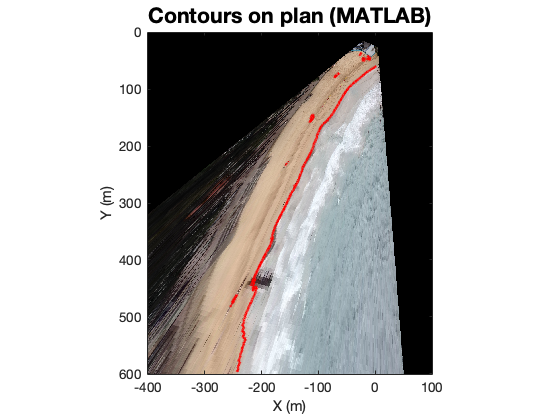

In [15]:
c = contours(X,Y,RminusBdouble,[thresh thresh]);
image(xgrid,ygrid,RminusBdouble)
hold on
contour(X,Y,RminusBdouble,[thresh thresh],'r','linewidth',2)
title('Contours of RmB threshold value (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight
figure
image(xgrid,ygrid,Iplan)
hold on
contour(X,Y,RminusBdouble,[thresh thresh],'r','linewidth',2)
title('Contours on plan (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

It can be seen from the plot above that several contours for the threshold value exist. Therefore the conour represnting the shoreline needs to be determined. 

>#### 3.5 Determine the contour representing the shoreline:

It is assumed that the contour resprensting the shoreline is the longest contour.<br>The arrangement of the ***contonur/countours*** output is represented below: <img src = 'ContourOutput.png' style = 'width:600px;height:240px'>

The contour value ('Level') and the number of vertices for that value are represented in the first column. Thereafter, the x and y coordinates of the vertices are provided. The value of the next contour and its number of vertices is then provided, followed by vertex coordinates and so on...

The **c** has been defined to only contain contours of the threshold 'level'. When the threshold 'level' is restated  in the **c** matrix, this represents the start of a separate contour. Therefore the number of columns after the threshold value is stated, until the next threshold value, indicates the size of the contour (number of vertices).
<br>**Note**: this method can only be used due to the single threshold 'level' existing in **c**. If other levels existed, the number of vertices indicated below the 'level' in the matrix (see diagram above) would have to be used to identify the contour size.

The matrix locations of elements representing the threshold 'level' and thus the start of a contour are found:

In [16]:
II = find(c(1,:)==thresh);

Below is an image of the current code for ***mapShorelineCCD.m*** <img src = 'contourIfLoop.png' style = 'width:600px;height:290px;float:left'/>

Essentially, if there is more than 1 contour, the largest contour is found using the else loop, with the ***diff( )*** 
function being used as to determine each contour's length. However, there are some problems with the else 
statement. These have been corrected below:

In [17]:
if II==1 %If only one line
    startI = 2;
    endI = size(c,2);
else
    D = diff(II);
    D = D - 1;
    D = [D (size(c,2) - II(end))];
    [~,J] = max(D); %Select contour that is the longest continuous contour
    if J == 1
        startI = 2;
    else
        startI = 1+J+sum(D(1:J-1));
    end
    endI = startI+D(J)-1;
end
xyz.x = c(1,startI:endI)';
xyz.y = c(2,startI:endI)';
points = [xyz.x xyz.y];

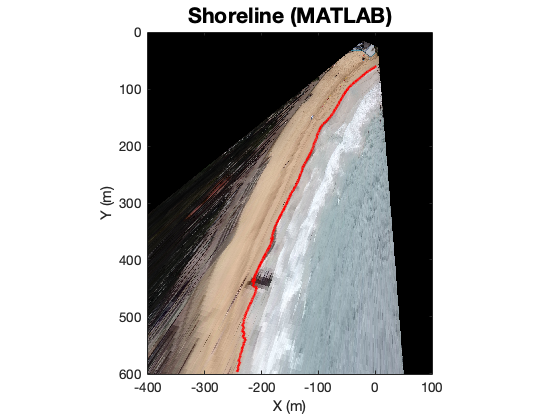

In [18]:
%plot inline
image(xgrid,ygrid,Iplan)
hold on
plot(xyz.x,xyz.y,'r-','linewidth',2)
title('Shoreline (MATLAB)','FontSize',16)
xlabel('X (m)')
ylabel('Y (m)')
axis equal
axis tight

**The corrections are:**
1. $D = D - 1$ (Previously $D = diff(II)$ was providing a value 1 unit too great for the number of vertices for the corresponding contour, getting this correct is important for the second else loop and $end I$)
2. $D = [D (size(c,2) - II(end))]$ (Previously the length (number of vertices) of the final contour was not represented in D, since $diff(II)$ only gave the differences between the threshold values so the elements after the final threshold were ignored)
3. $endI = startI+D(J)-1$ (Previously there was an extra $-J$ which should not be there. It has worked okay until now because it seems that the longest contour always occurs at the start and since previously $D$ was over estimated by 1, this $- J$ (ie $- 1$) inadvertently resulted in the two mistakes cancelling each others' effect.
4. $xyz.x$ and $xyz.y$ have been swapped in the last 3 lines (to correctly match their representation of the values in $c$). Previously this was not a problem either becuase the arrangement was still made correctly in the $points$ matrix, however, to avoid any future confusion, it would be best to correct.

> #### 3.6 Extract the shoreline points at the transects only

A for loop is used here in order to extract 1 shoreline point for each transect. Below, the method for this is presented. Afterwards, the complete for loop is performed to generate all the desired shoreline points.

First the structure, **sl** is created which will hold the x and y coordinate of the shoreline for all of the transects.

In [19]:
%Now loop through transects to extract shorelines only at the transects
sl.x = NaN(1,length(transects.x));
sl.y = NaN(1,length(transects.y));

Next, the for loop counter determines the current transect to be used (for this demonstration, let's say the counter is at 60, so we are finding the location of the shoreline along the 60th transect). The angle between this transect and the horizontal (x-axis) is determined:

In [20]:
angle = atan(diff(transects.y(:,60))/diff(transects.x(:,60)));

The next step uses the ***rotatePoints*** function. This function performs the following steps:

1. The point representing the start of the transect (called the rotation centre here) is subtracted from all the shoreline points:

In [21]:
%First subtract rotation_center
points_new = points(:,1:2) - repmat([transects.x(1,60) transects.y(1,60)],size(points,1),1);

2. The shore line is rotated about the start of the transect (rotation centre).

In [22]:
%Now rotate the points
points_rot = points_new*[cos(angle) -sin(angle); sin(angle) cos(angle)];

Essentially these steps of the **rotatePoints** function realign the transect and the shoreline within the axes so that the start of the transect is located at (0,0) and runs along the x-axis. The plots generated by the cell below provide a visulaisation for this:

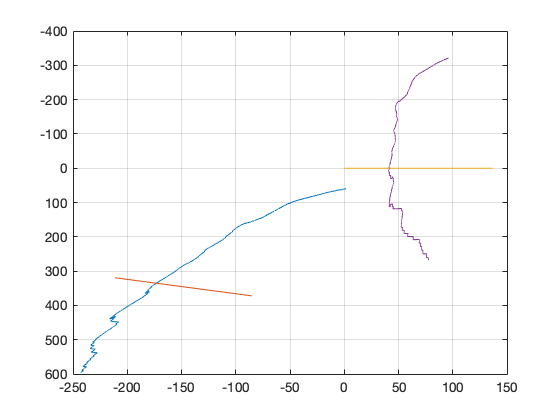

In [23]:
plot(points(:,1),points(:,2))
grid on
axis ij
hold on
plot(transects.x(:,60),transects.y(:,60))
A = [transects.x(:,60) transects.y(:,60)];
A_new = A - repmat([transects.x(1,60) transects.y(1,60)],2,1);
A_rot = A_new*[cos(angle) -sin(angle); sin(angle) cos(angle)];
plot(A_rot(:,1),A_rot(:,2))
plot(points_rot(:,1),points_rot(:,2))

In [24]:
plot(points(:,1),points(:,2))
axis ij
hold on
plot(transects.x(:,60),transects.y(:,60))
plot(points(905:910,1),points(905:910,2),'rx')
A = [transects.x(:,60) transects.y(:,60)];
>> A_trans = A - repmat([transects.x(1,60) transects.y(1,60)],2,1);
A_rot = A_trans*[cos(angle) -sin(angle); sin(angle) cos(angle)];
plot(A_rot(:,1),A_rot(:,2))
>> plot(points_rot(:,1),points_rot(:,2))
>> plot(points_rot(905:910,1),points_rot(905:910,2),'rx')

Error: Invalid use of operator.

